In [6]:
import csv
import os
from datetime import datetime
import math
import matplotlib.pyplot as plt
import numpy as np

options_dir = '../data/options_data'
for ticker in os.listdir(options_dir):
    ticker_dir = options_dir + '/' + ticker
    put_files = []
    for file in os.listdir(ticker_dir):
        file_heruistics = file.split('_')
        strike = file_heruistics[2].split('-', 1)
        expiry_date = datetime.strptime(file_heruistics[1], '%Y%m%d').date()

        if 'p' in strike[0].replace('.csv', ''):
            put_files.append((file, expiry_date))

    put_files.sort(key=lambda contract: contract[1])

    # this is merely because there is one extra put file for AMD and I didn't want to delete it in case it was used in another strat
    # ERIC- THIS IS LUCAS: I deleted the extra file in amd's folder so this shouldnt be necassary anymore 
    #if ticker == "AMD":
    #    put_files = put_files[1:]

    # implement married puts strategy
    balance = 100000
    ownUnderlying = False
    share_count = 0 # in hundreds

    csv_data = []

    for file, expiry_date in put_files:
        print(file, expiry_date)
        with open(os.path.join(ticker_dir, file), 'r') as f:
            strike_csv = csv.reader(f)
            row = list(strike_csv)
            for index, line in reversed(list(enumerate(row[0:len(row)-1]))):
                    date = datetime.strptime(line[0], '%m/%d/%Y').date()
                    if date.month == expiry_date.month:
                        start_open = float(row[index][1])
                        strike_price = float(row[index][16])
                        start_price = float(row[index][15])
                        end_price = float(row[1][15])
                        break
            print(f"{start_open}, {strike_price}, {start_price}, {end_price}")
            
            puts_purchased = 0

            # if no shares are owned, buy shares and puts
            if not ownUnderlying:
                # find out how many shares and puts we can buy and purchase them
                puts_purchased = share_count = math.floor(balance / (100 * (start_open + start_price)))
                share_cost = start_price * 100 * share_count
                put_cost = start_open * 100 * share_count
                balance -= share_cost + put_cost
                ownUnderlying = True
            # else shares are owned meaning last month's puts expired 'out of the money', repurchase as many puts as we can with available balance at new strike
            # if not enough balance, sell 100 shares, check balance and buy as many puts as we can with max = share_count
            else:
                # find number of puts can buy with balance with max being the share_count
                x = min(math.floor(balance / (100*start_open)), share_count)
                while share_count and not x:
                    share_count -= 1
                    share_sale = 100 * start_price
                    balance += share_sale
                    x = min(math.floor(balance / (100*start_open)), share_count)
                    
                puts_purchased = x
                put_cost = start_open * 100 * puts_purchased
                balance -= put_cost

            # exercise puts if stock falls below strike price at EOM
            if end_price < strike_price:
                put_sale = share_count * 100 * strike_price
                balance += put_sale

                ownUnderlying = False
                share_count = 0
            
            # balance + EOM shares value = accnt value (8968 + 95376 = 104344)
            shares_value_eom = share_count * 100 * end_price
            account_value = balance + shares_value_eom
            
            # obtain 'results'
            net_percentage = ((account_value - 100000) / 100000) * 100
            net_return = account_value - 100000

            csv_data.append([expiry_date, date, strike_price, start_price, end_price, start_open, puts_purchased, account_value, balance, net_percentage, net_return])


        with open('../data/outputs/married_puts/' + ticker + '.csv', 'w+', newline="") as f:
            writer = csv.writer(f)
            header = ['Expiration Date', 'Date Put Bought', 'Strike Price', 'Starting asset price', 'Ending Asset Price', 'Price Per Put', 'Puts Bought', 'Account Value EOM', 'Cash Balance EOM', 'Percent Change', 'Profit Amount']
            variables = ['expiry_date',  'date',               'strike_price',      'start_price',            'end_price',        'start_open', 'share_count', 'account_value', 'balance', 'net_percentage', 'net_return']
            print(len(header), len(variables))
            print(header[10])
            writer.writerow(header)

            for row in csv_data:
                writer.writerow(row)

price-history-for-amd_20191129_35.00p-11-22-2021.csv 2019-11-29
1.44, 35.0, 34.89, 39.15
11 11
Profit Amount
price-history-for-amd_20191227_40.00p-11-22-2021.csv 2019-12-27
2.05, 40.0, 38.73, 46.18
11 11
Profit Amount
price-history-for-amd_20200131_50.00p-11-22-2021.csv 2020-01-31
4.45, 50.0, 49.1, 47.0
11 11
Profit Amount
historical-data-download-amd_20200228_50.00p-11-22-2021.csv 2020-02-28
4.4, 50.0, 48.02, 45.48
11 11
Profit Amount
price-history-for-amd_20200327_45.00p-11-22-2021.csv 2020-03-27
2.83, 45.0, 47.46, 46.58
11 11
Profit Amount
historical-data-download-amd_20200424_45.00p-11-22-2021.csv 2020-04-24
2.73, 45.0, 43.66, 56.18
11 11
Profit Amount
price-history-for-amd_20200529_50.00p-11-22-2021.csv 2020-05-29
2.45, 50.0, 49.9, 53.8
11 11
Profit Amount
historical-data-download-amd_20200626_55.00p-11-22-2021.csv 2020-06-26
3.39, 55.0, 53.63, 50.1
11 11
Profit Amount
price-history-for-amd_20200731_55.00p-11-22-2021.csv 2020-07-31
5.01, 55.0, 52.58, 77.43
11 11
Profit Amount
pric

AMD.csv
data points: 24
x-axis values: ['11/2019', '12/2019', '1/2020', '2/2020', '3/2020', '4/2020', '5/2020', '6/2020', '7/2020', '8/2020', '9/2020', '10/2020', '11/2020', '12/2020', '1/2021', '2/2021', '3/2021', '4/2021', '5/2021', '6/2021', '7/2021', '8/2021', '9/2021', '10/2021']
y-axis values: [107614.0, 124750.0, 130079.0, 124271.0, 115367.0, 134858.0, 123856.0, 121055.0, 162719.0, 171493.0, 171776.0, 159788.0, 176728.0, 183748.0, 172378.0, 162190.0, 152687.0, 147341.0, 144319.0, 150155.0, 180724.0, 182936.0, 176094.0, 197486.0]
y2-axis vals: [249810.88, 199389.0, 222141.4, 208961.3, 173290.66, 132993.89, 137474.54, 128396.86, 145883.04, 149170.79, 166831.54, 169595.58, 119057.32, 138551.06, 164242.07, 125283.68, 53069.54, 56531.86, 52429.44, 32324.7, 32324.7, 36747.16, 33430.32, 13907.48]


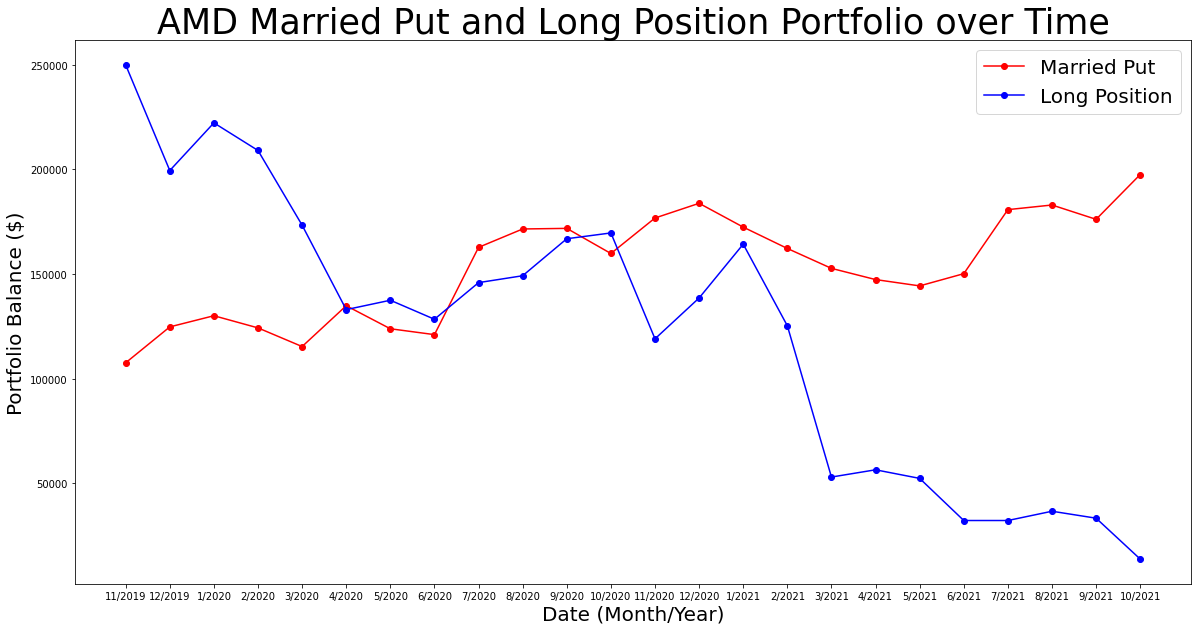

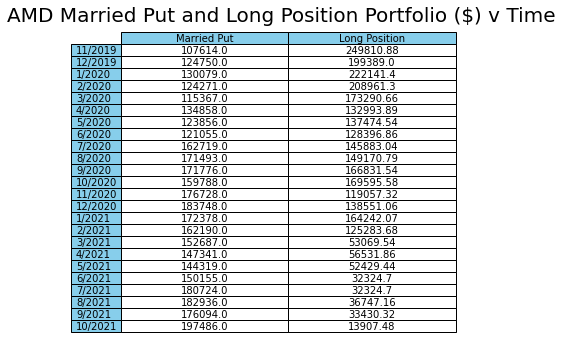

F.csv
data points: 24
x-axis values: ['11/2019', '12/2019', '1/2020', '2/2020', '3/2020', '4/2020', '5/2020', '6/2020', '7/2020', '8/2020', '9/2020', '10/2020', '11/2020', '12/2020', '1/2021', '2/2021', '3/2021', '4/2021', '5/2021', '6/2021', '7/2021', '8/2021', '9/2021', '10/2021']
y-axis values: [97516.0, 100908.0, 97100.0, 94527.0, 87777.0, 88988.0, 86520.0, 88650.0, 93882.0, 93915.0, 101226.0, 106622.0, 120638.0, 124201.0, 137406.0, 158926.0, 177104.0, 168793.0, 182651.0, 204071.0, 197652.0, 192583.0, 195403.0, 240829.0]
y2-axis vals: [97685.19, 63888.89, 50810.19, 61458.33, 71990.74, 68171.3, 33564.81, 41782.41, 35416.67, 21875.0, 1736.11, 5092.59, -10532.41, -22916.67, -21064.81, -23495.37, -29629.63, -33912.04, -41087.96, -44097.22, -19444.44, 2083.33, 7638.89, 4861.11]


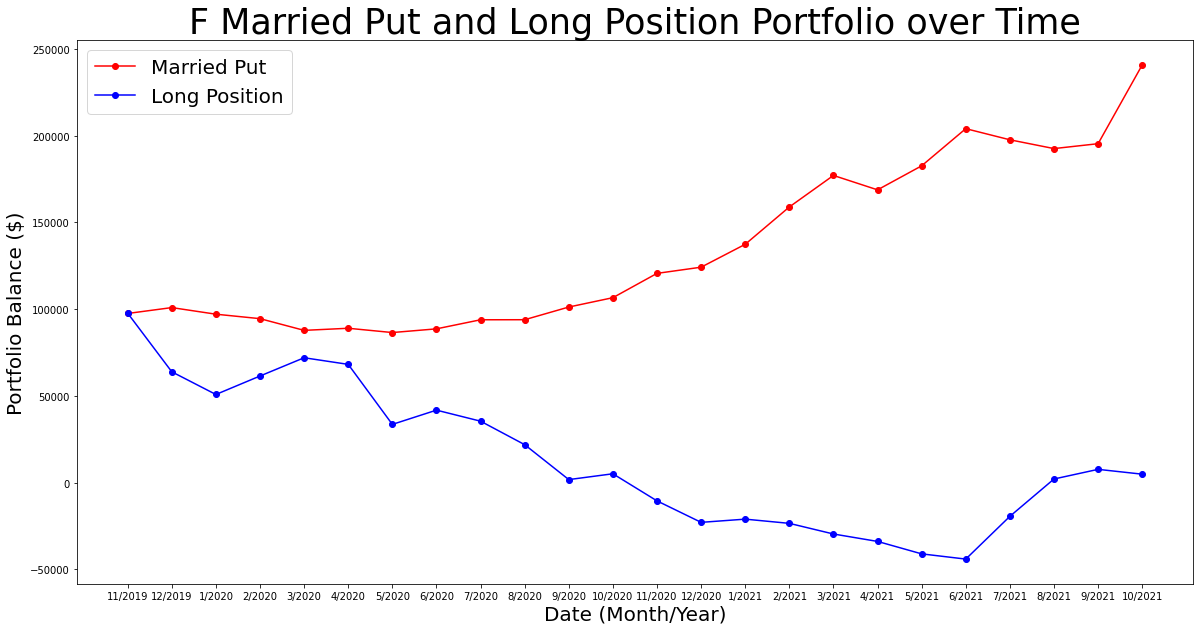

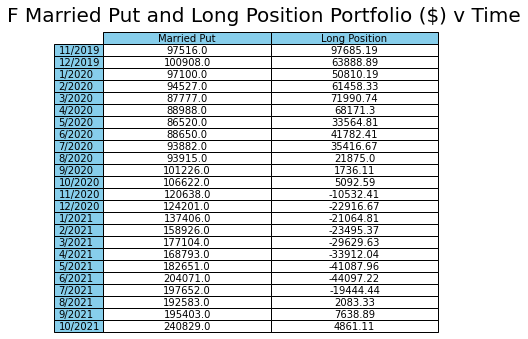

GM.csv
data points: 24
x-axis values: ['11/2019', '12/2019', '1/2020', '2/2020', '3/2020', '4/2020', '5/2020', '6/2020', '7/2020', '8/2020', '9/2020', '10/2020', '11/2020', '12/2020', '1/2021', '2/2021', '3/2021', '4/2021', '5/2021', '6/2021', '7/2021', '8/2021', '9/2021', '10/2021']
y-axis values: [96204.0, 97426.0, 96254.0, 98578.0, 84073.0, 88831.0, 88338.0, 101129.0, 92594.0, 99020.0, 107141.0, 110890.0, 142157.0, 141361.0, 155404.0, 163124.0, 179541.0, 170374.0, 162641.0, 159339.0, 157363.0, 153541.0, 156841.0, 173473.0]
y2-axis vals: [46277.88, 41655.47, 31711.91, 52754.64, 59016.39, 59392.64, 53775.87, 54420.85, 37946.79, 36199.95, 11905.4, 17817.79, -7202.36, -20478.37, -20370.87, -33109.38, -32007.52, -30448.8, -40096.75, -44154.8, -18032.79, -10266.06, -1639.34, -3251.81]


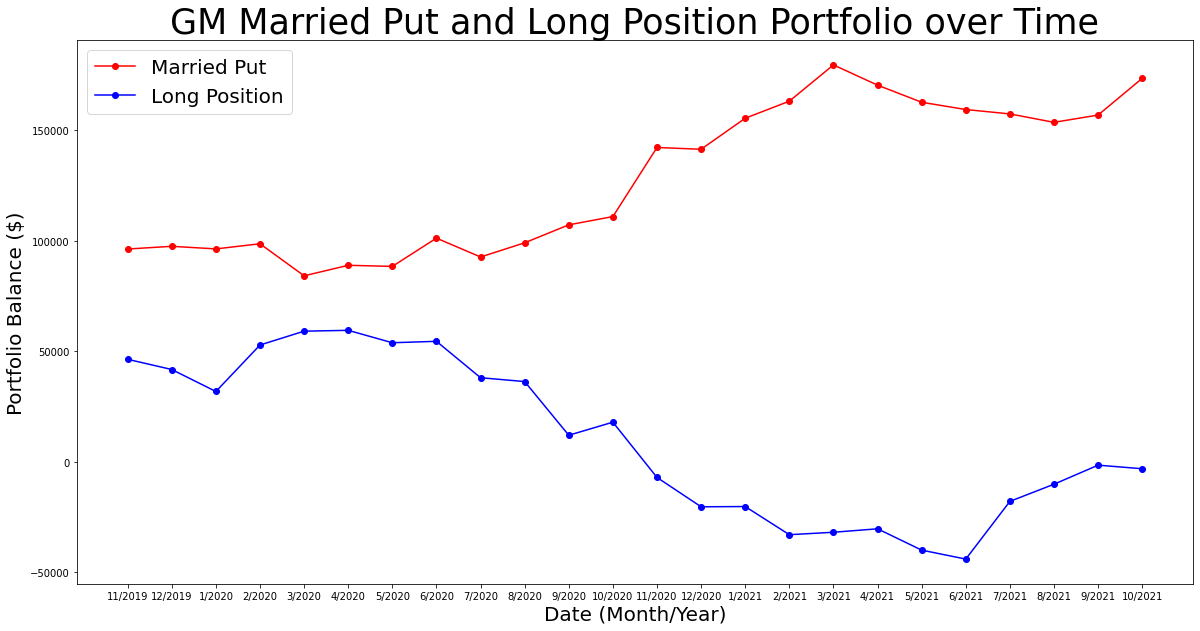

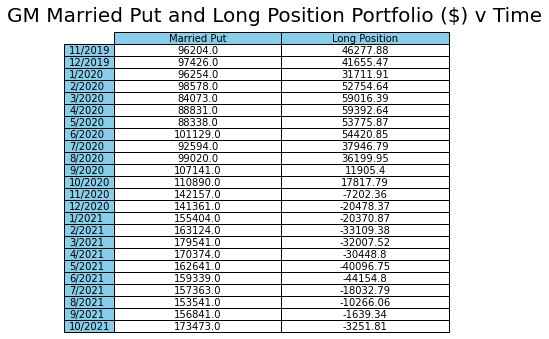

MSFT.csv
data points: 24
x-axis values: ['11/2019', '12/2019', '1/2020', '2/2020', '3/2020', '4/2020', '5/2020', '6/2020', '7/2020', '8/2020', '9/2020', '10/2020', '11/2020', '12/2020', '1/2021', '2/2021', '3/2021', '4/2021', '5/2021', '6/2021', '7/2021', '8/2021', '9/2021', '10/2021']
y-axis values: [103678.0, 106924.0, 112198.0, 108100.0, 96946.0, 102781.0, 105081.0, 108371.0, 109461.0, 116986.0, 113281.0, 108906.0, 111181.0, 112016.0, 119526.0, 115643.0, 112819.0, 115259.0, 112751.0, 117943.0, 122279.0, 124683.0, 123575.0, 135259.0]
y2-axis vals: [129876.61, 95424.93, 109261.06, 97497.57, 87785.94, 73076.39, 74809.37, 63434.08, 61084.15, 60793.01, 54179.95, 48391.79, 40350.76, 45799.25, 56335.78, 42111.47, 41071.68, 27027.59, 24227.09, 9323.44, 12304.17, 18002.22, 9316.51, 4935.53]


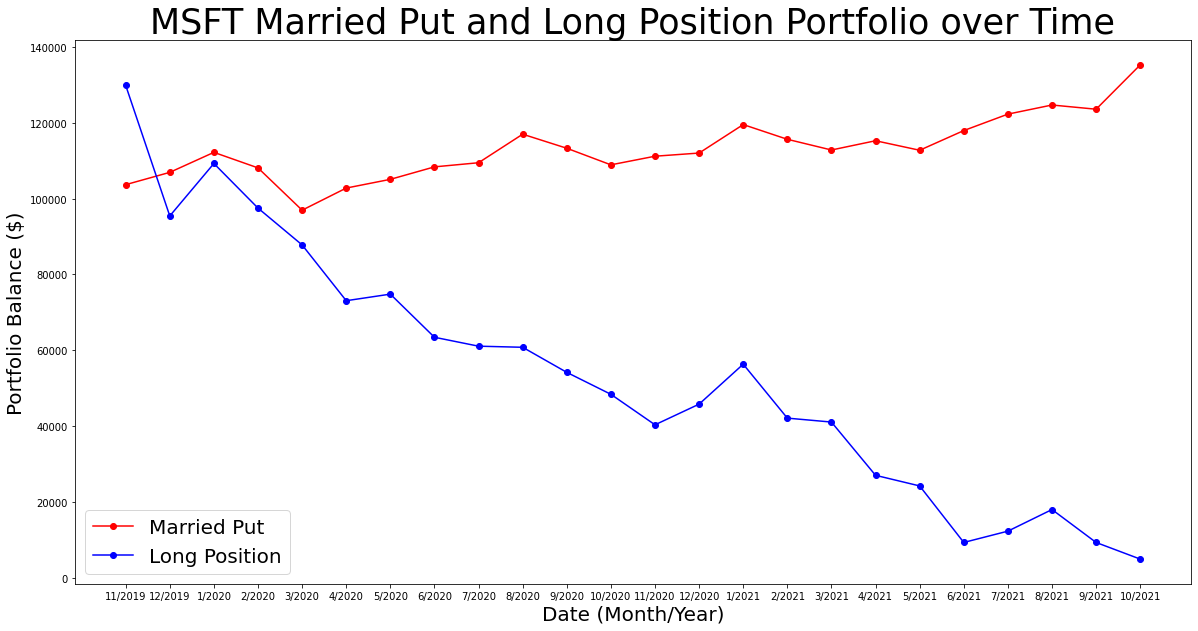

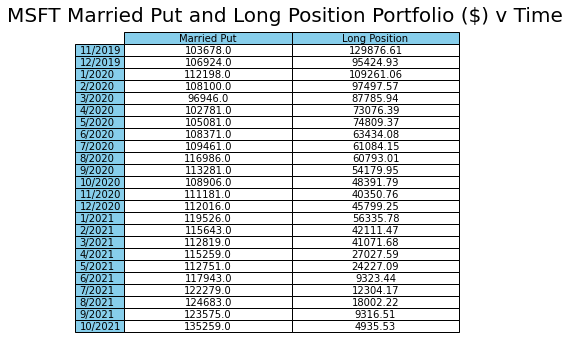

In [7]:
# graph results

outputs = '../data/outputs/married_puts/'
historical_outputs = '../data/outputs/historical_returns/'
files = [f for f in os.listdir(outputs) if os.path.isfile(os.path.join(outputs, f))]

for file in files:
    with open(os.path.join(outputs, file), 'r') as f:
        output_csv = csv.reader(f)
        rows = list(output_csv)
        
        profits = []
        monthly_balance = []
        months = []
        long_monthly_bal = []

        for line in rows[1:]:
            profits.append(round(float(line[10]), 2))
            monthly_balance.append(round(float(line[7]),2))
            date = datetime.strptime(line[0], "%Y-%m-%d").date()
            months.append(str(date.month) + '/' + str(date.year))

    with open(os.path.join(historical_outputs, file), 'r') as f:
        output_csv = csv.reader(f)
        rows = list(output_csv)
        for line in rows[1:]:
            long_monthly_bal.append(float(line[5]))
    
    long_monthly_bal.reverse()

    print(file)
    print("data points: " + str(len(monthly_balance)))
    print('x-axis values: ' + str(months))
    print('y-axis values: ' + str(monthly_balance))
    print('y2-axis vals: ' + str(long_monthly_bal))


    x1 = months
    y1 = monthly_balance
    y2 = long_monthly_bal

    plt.figure(figsize=(20,10))
    plt.rcParams['font.size'] = '10'
    plt.plot(x1, y1, color='red', marker='o', label="Married Put")
    plt.plot(x1, y2, color='blue', marker='o', label='Long Position')
    plt.xlabel("Date (Month/Year)", fontsize=20)
    plt.ylabel("Portfolio Balance ($)", fontsize=20)
    plt.title(file.replace('.csv', '') + ' Married Put and Long Position Portfolio over Time', fontsize=35)
    plt.legend(fontsize=20)

    plt.savefig('../data/outputs/married_puts/graphs/' + file.replace('.csv', '') + '_balance_v_time.jpg')
    plt.show()

    columns = ('Married Put', 'Long Position')
    rows = ['%s' % x for x in months]
    nparr1 = np.array(monthly_balance)
    nparr2 = np.array(long_monthly_bal)

    np2d = np.vstack((nparr1, nparr2)).T
    
    fig, ax = plt.subplots() 
    ax.set_axis_off() 
    table = ax.table( 
        cellText = np2d,  
        rowLabels = rows,  
        colLabels = columns, 
        rowColours =["skyblue"] * 24,  
        colColours =["skyblue"] * 24, 
        cellLoc ='center',  
        loc ='upper left')         
    
    ax.set_title(file.replace('.csv', '') + ' Married Put and Long Position Portfolio ($) v Time',
                fontsize=20)

    plt.savefig('../data/outputs/married_puts/graphs/' + file.replace('.csv', '') + '_data_table.jpg',
                bbox_inches='tight', dpi=150)
    plt.show() 